# Solar Power Forecasting Using Vector Auto Regression

1. Read labeled data from output.xlsx
2. Set forecast_days
3. Generate probabilistic labels
4. Run VAR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
#run mark

In [3]:
forecast_days = 10

In [4]:
xls = pd.ExcelFile("output.xlsx")

In [5]:
#years = ["2012","2013","2014","2015","2016","2017","2018","2019","2020"]
years=xls.sheet_names[:-1]

In [6]:
df_obj = {}
for i in years:
    df_obj[i] = pd.read_excel(xls, i)
    df_obj[i] = df_obj[i].drop(["Unnamed: 0"],axis=True)

In [7]:
df_obj

{'2012':           Date  1104500527  1104500529  1.104501e+09  7802195.0  \
 0   2012-07-06         679         825           837      869.0   
 1   2012-07-07         882         899           910      924.0   
 2   2012-07-08        1051        1080          1091     1129.0   
 3   2012-07-09        1114        1136          1148     1172.0   
 4   2012-07-10         153         159           170      162.0   
 ..         ...         ...         ...           ...        ...   
 174 2012-12-27        1199        1217          1187     1149.0   
 175 2012-12-28        1147        1182          1125     1054.0   
 176 2012-12-29        1074        1125          1057     1021.0   
 177 2012-12-30        1029        1068          1007      973.0   
 178 2012-12-31        1035        1080          1012      984.0   
 
     2100570073/ 2100567820/ 2100567898  Total Generation (KWH)  \
 0                                    8                 3218.00   
 1                                   18 

## Forecasting start

In [8]:
df_obj['2015'].columns

Index(['Date', '1104500527', '1104500529', '1.104501e+09', '7802195.0',
       '2100570073/ 2100567820/ 2100567898', 'Total Generation (KWH)',
       'Aggregate Meter Reading (KWH)', 'Difference', 'SEEDs data (KWH)',
       'Insolation', 'PR (%)', 'Any Issues/Problems Observed', 'WO#',
       'NO-OFF-CLEAN MODULES', 'Grid Failure', 'Inverter', 'Module Cleaning',
       'Rainy day', 'No Module Cleaning',
       'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
       'Plant Shutdown', 'Internet', 'Battery', 'Cloudy',
       'Module Cleaning by rains'],
      dtype='object')

In [9]:
df = df_obj['2012']
# df = df.append(df_obj['2016'])

for i in range(2013,2019):
    df = df.append(df_obj[str(i)])
    
df1 = df.drop(["1104500527", "1104500529", "1.104501e+09", "7802195.0", "2100570073/ 2100567820/ 2100567898", 
                    "Aggregate Meter Reading (KWH)", 
                    "Difference", "SEEDs data (KWH)",  
                    "PR (%)", "Any Issues/Problems Observed", "WO#"], axis=1)

C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_21652\2415086572.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_21652\2415086572.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_21652\2415086572.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_21652\2415086572.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipyk

In [10]:
df1['Insolation'] = df1['Insolation'].fillna(df1['Insolation'].mean())
# df1 = df1.fillna(0)
df1['NO-OFF-CLEAN MODULES'] = df1['NO-OFF-CLEAN MODULES'].replace(r'^\s*$', np.nan, regex=True)
df1['NO-OFF-CLEAN MODULES'] = df1['NO-OFF-CLEAN MODULES'].fillna(0)

In [11]:
df1['NO-OFF-CLEAN MODULES'] = pd.to_numeric(df1['NO-OFF-CLEAN MODULES'])

In [12]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.set_index('Date')

In [13]:
df1

,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
Date,,,,,,,,,,,,,,,
2012-07-06,3218.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-07,3633.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-08,4377.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-09,4625.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-10,648.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,4129.29,5.74700,1,0,1,0,0,0,0,0,0,0,0,0,971.0
2018-12-28,4266.50,5.68900,0,0,1,0,0,0,0,0,0,0,0,0,0.0
2018-12-29,3732.03,5.83400,1,0,1,0,0,0,0,0,0,0,0,0,720.0


In [14]:
# for i in df1.columns[1:]:
#     print(i)
#     temp = df1[i].value_counts().to_dict()
#     print(temp)
#     if 1.0 in temp.keys():
#         df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**12

In [15]:
df1['Total Generation (KWH)'] = pd.to_numeric(df1['Total Generation (KWH)'])
df1['Total Generation (KWH)'].dtype

dtype('float64')

In [16]:
df1['Module Cleaning by rains'].unique()


array([0], dtype=int64)

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2370 entries, 2012-07-06 to 2018-12-31
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Total Generation (KWH)                   2370 non-null   float64
 1   Insolation                               2370 non-null   float64
 2   Grid Failure                             2370 non-null   int64  
 3   Inverter                                 2370 non-null   int64  
 4   Module Cleaning                          2370 non-null   int64  
 5   Rainy day                                2370 non-null   int64  
 6   No Module Cleaning                       2370 non-null   int64  
 7   Transformer replacement and maintenance  2370 non-null   int64  
 8   Cable and Fuse maintenance               2370 non-null   int64  
 9   Plant Shutdown                           2370 non-null   int64  
 10  Internet                      

In [18]:
df1.describe()

,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.0,2.370000e+03
mean,3968.274734,9.375360,0.362025,0.102532,0.336287,0.018565,0.036287,0.008017,0.027848,0.000422,0.025316,0.011392,0.169198,0.0,1.133006e+04
std,1130.524750,91.909923,0.480688,0.303410,0.472538,0.135013,0.187043,0.089196,0.164572,0.020541,0.157118,0.106148,0.375006,0.0,5.406768e+05
min,0.000000,0.451000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00
25%,3347.177500,5.380250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00
50%,4198.810000,6.255000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00
75%,4785.212500,9.375360,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.040000e+02
max,6147.740000,4240.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,2.632180e+07


In [19]:
corr_df = df1.corr()
# corr_df[corr_df < 0] = 0
corr_df

,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
Total Generation (KWH),1.000000,-0.024524,-0.130600,-0.314601,0.128121,-0.243720,-0.005216,-0.050500,0.032419,0.014604,0.058770,-0.042502,-0.430203,NaN,-0.009910
Insolation,-0.024524,1.000000,-0.014171,0.003589,-0.019096,-0.007896,-0.005430,-0.002112,-0.005786,-0.000670,-0.001732,-0.003606,-0.010411,NaN,-0.000011
Grid Failure,-0.130600,-0.014171,1.000000,0.057966,0.028741,0.006965,-0.071054,-0.008649,-0.004769,0.027274,0.007146,-0.006409,-0.026162,NaN,0.027293
Inverter,-0.314601,0.003589,0.057966,1.000000,-0.240594,0.345086,-0.065587,0.047602,-0.057207,-0.006944,-0.045619,0.107890,0.170230,NaN,-0.007084
Module Cleaning,0.128121,-0.019096,0.028741,-0.240594,1.000000,-0.097901,-0.138123,0.046175,0.036938,0.028864,-0.103348,-0.076412,-0.206888,NaN,0.029442
Rainy day,-0.243720,-0.007896,0.006965,0.345086,-0.097901,1.000000,-0.026688,0.022688,-0.004281,-0.002826,-0.022166,-0.014764,0.304770,NaN,-0.002883
No Module Cleaning,-0.005216,-0.005430,-0.071054,-0.065587,-0.138123,-0.026688,1.000000,-0.017444,0.008297,-0.003987,-0.031273,-0.020830,0.032792,NaN,-0.004067
Transformer replacement and maintenance,-0.050500,-0.002112,-0.008649,0.047602,0.046175,0.022688,-0.017444,1.000000,-0.015215,-0.001847,-0.014488,-0.009650,-0.027950,NaN,-0.001812
Cable and Fuse maintenance,0.032419,-0.005786,-0.004769,-0.057207,0.036938,-0.004281,0.008297,-0.015215,1.000000,-0.003477,-0.027277,0.054323,-0.014822,NaN,-0.003460
Plant Shutdown,0.014604,-0.000670,0.027274,-0.006944,0.028864,-0.002826,-0.003987,-0.001847,-0.003477,1.000000,-0.003311,-0.002206,-0.009272,NaN,-0.000431


<AxesSubplot: >

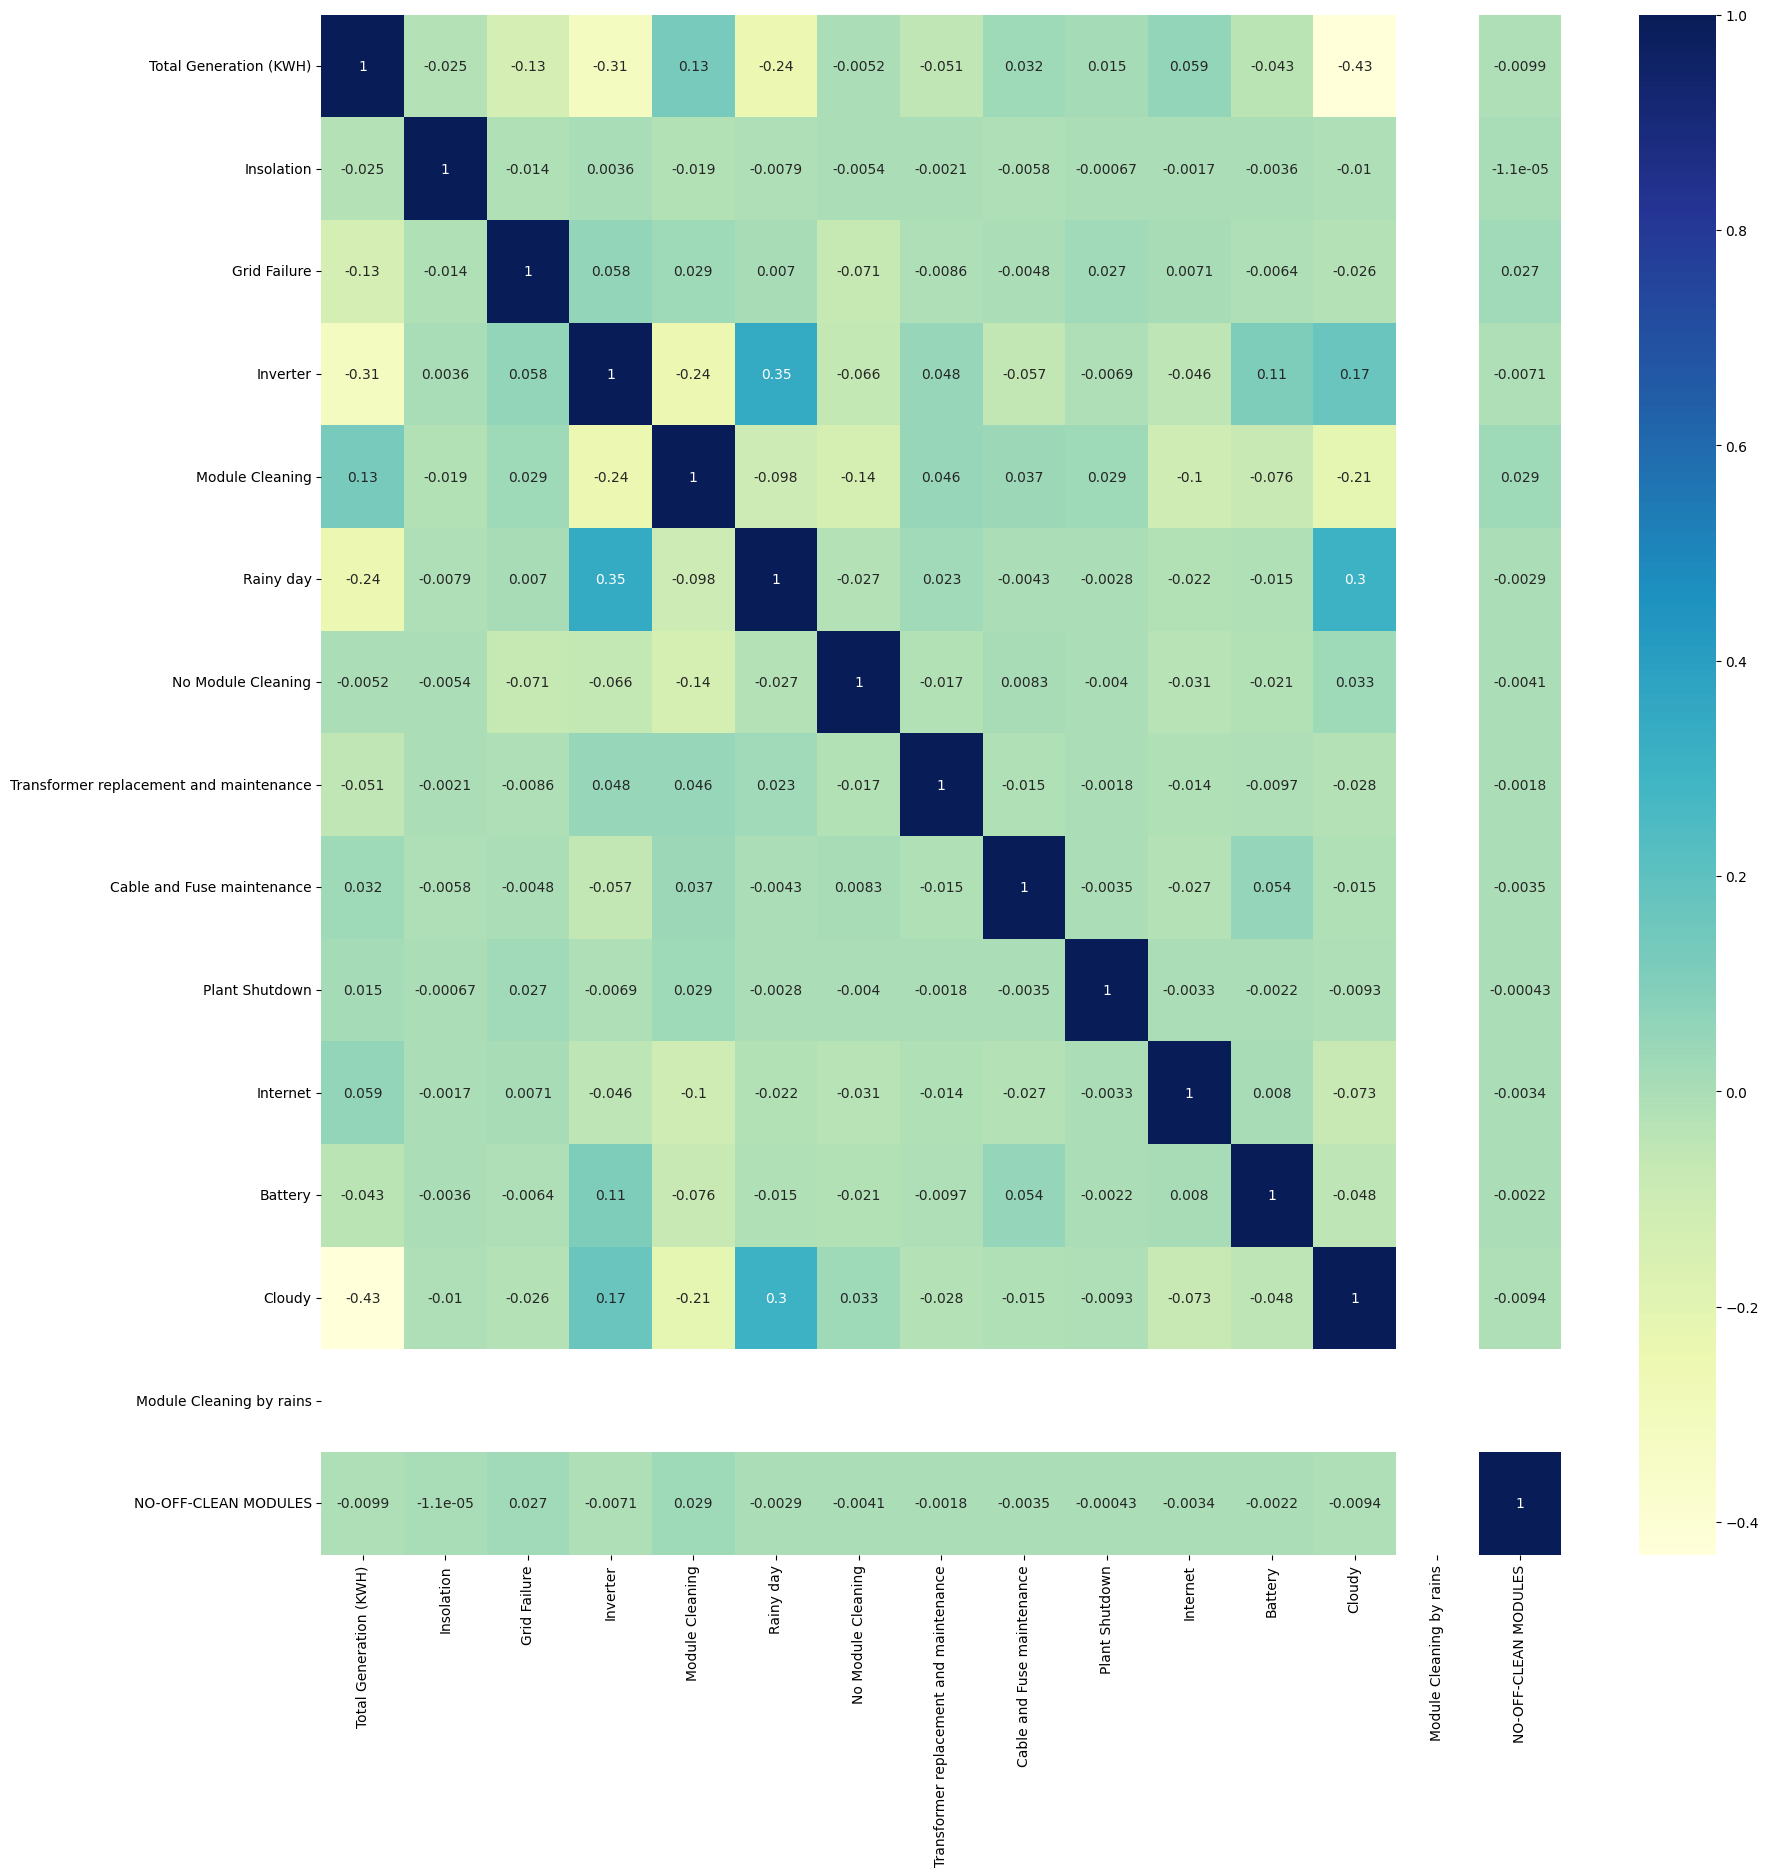

In [20]:
plt.figure(figsize=(20,20))
sns.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

In [21]:
#df1.to_csv('out_clean.csv')

In [22]:
# total_0 = 0
# total_1 = 0
# for i in df1.columns[1:]:
#     value_c = df1[i].value_counts()
#     print(df1[i].value_counts())
#     total_0 += value_c[]

In [23]:
df1 = df1.drop(["Cable and Fuse maintenance","NO-OFF-CLEAN MODULES", "No Module Cleaning","Rainy day", "Insolation" ,"Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rains"], axis=1)
df1

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2012-07-06,3218.00,1,0,0,0
2012-07-07,3633.00,1,0,0,0
2012-07-08,4377.00,0,1,0,0
2012-07-09,4625.00,0,1,0,0
2012-07-10,648.00,0,1,0,0
...,...,...,...,...,...
2018-12-27,4129.29,1,0,1,0
2018-12-28,4266.50,0,0,1,0
2018-12-29,3732.03,1,0,1,0


In [24]:
endog_array = df1.to_numpy(dtype=int)

In [102]:
endog_array.shape

(2370, 5)

In [25]:
var_model = VAR(endog_array)

In [26]:
var_model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,6.275,6.288,531.3,6.280
1,3.395,3.470,29.82,3.422
2,3.140,3.276,23.11,3.190
3,3.041,3.239,20.92,3.113
4,2.998,3.258,20.04,3.092
5,2.966,3.288,19.42,3.084
6,2.942,3.326,18.95,3.082
7,2.695,3.141*,14.81,2.858
8,2.647,3.154,14.11,2.832*
9,2.644,3.214,14.07,2.852


In [27]:
results = var_model.fit(15, trend='c', ic='aic')

In [28]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jan, 2023
Time:                     11:05:46
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    3.51735
Nobs:                     2355.00    HQIC:                   2.92594
Log likelihood:          -19374.5    FPE:                    13.2944
AIC:                      2.58723    Det(Omega_mle):         11.3422
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        429.308862       103.472155            4.149           0.000
L1.y1          0.565818         0.021648           26.137           0.000
L1.y2         96.226095        31.150276            3.089           0.002
L1.y3        -94.

0.021648100160669714
0.024771498679911134
0.02483676245533021
0.02484293566716312
0.02485842128766958
0.02494038762929336
0.02494226924866748
0.024933831372270194
0.024951523287980438
0.02499256781209973
0.024856171237430127
0.024763893249157908
0.024791016757388814
0.024788014767129548
0.021828458838513243


Text(0, 0.5, 'std. error')

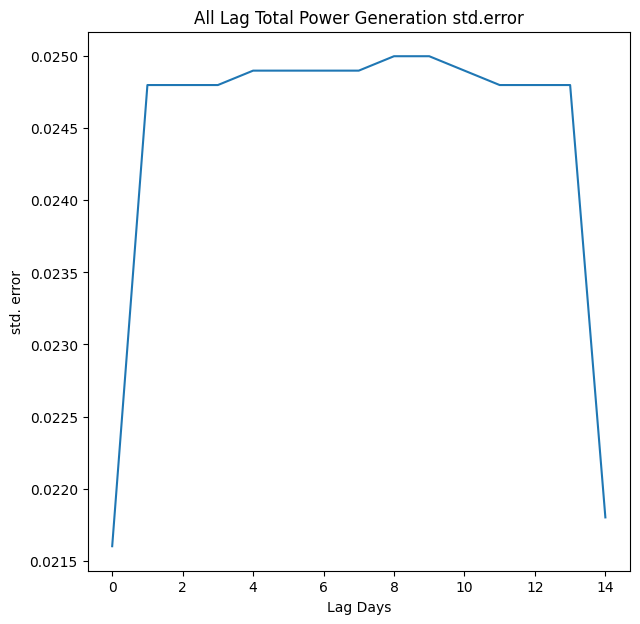

In [29]:
stderr_value = list(results.stderr)[1:]
error_value = []
for i in range(75):
    if i % 5 == 0:
        print(stderr_value[i][0])
        error_value.append(round(stderr_value[i][0],4))
fig = plt.figure(figsize=(7,7))
plt.plot(error_value)    
plt.title("All Lag Total Power Generation std.error")
plt.xlabel('Lag Days')
plt.ylabel('std. error')

In [30]:
# fig.savefig('std_error')

In [31]:
for i in list(results.stderr):
    for j in i:
        print(round(j,3))

103.472
0.071
0.033
0.041
0.027
0.022
0.0
0.0
0.0
0.0
31.15
0.021
0.01
0.012
0.008
67.859
0.046
0.022
0.027
0.018
54.294
0.037
0.017
0.022
0.014
81.286
0.055
0.026
0.032
0.021
0.025
0.0
0.0
0.0
0.0
31.341
0.021
0.01
0.013
0.008
70.966
0.048
0.023
0.028
0.019
55.56
0.038
0.018
0.022
0.015
90.551
0.062
0.029
0.036
0.024
0.025
0.0
0.0
0.0
0.0
31.38
0.021
0.01
0.013
0.008
71.634
0.049
0.023
0.029
0.019
55.851
0.038
0.018
0.022
0.015
91.038
0.062
0.029
0.036
0.024
0.025
0.0
0.0
0.0
0.0
31.297
0.021
0.01
0.012
0.008
71.63
0.049
0.023
0.029
0.019
56.242
0.038
0.018
0.022
0.015
91.411
0.062
0.029
0.036
0.024
0.025
0.0
0.0
0.0
0.0
31.287
0.021
0.01
0.012
0.008
71.512
0.049
0.023
0.029
0.019
56.265
0.038
0.018
0.022
0.015
91.623
0.063
0.029
0.037
0.024
0.025
0.0
0.0
0.0
0.0
31.241
0.021
0.01
0.012
0.008
71.31
0.049
0.023
0.028
0.019
56.203
0.038
0.018
0.022
0.015
91.539
0.062
0.029
0.037
0.024
0.025
0.0
0.0
0.0
0.0
31.192
0.021
0.01
0.012
0.008
71.222
0.049
0.023
0.028
0.019
56.133
0.038
0.018
0

In [32]:
for index, i in enumerate(list(results.stderr)):
    print(index, i)

0 [1.03472155e+02 7.06148308e-02 3.31345858e-02 4.12717604e-02
 2.73032639e-02]
1 [2.16481002e-02 1.47738001e-05 6.93230784e-06 8.63474047e-06
 5.71229808e-06]
2 [3.11502756e+01 2.12585835e-02 9.97516172e-03 1.24248569e-02
 8.21964322e-03]
3 [6.78586017e+01 4.63102724e-02 2.17301617e-02 2.70666437e-02
 1.79058928e-02]
4 [5.42935245e+01 3.70527515e-02 1.73862567e-02 2.16559647e-02
 1.43264671e-02]
5 [8.12858784e+01 5.54737509e-02 2.60299392e-02 3.24223584e-02
 2.14489569e-02]
6 [2.47714987e-02 1.69053712e-05 7.93250462e-06 9.88056506e-06
 6.53647125e-06]
7 [3.13406321e+01 2.13884927e-02 1.00361190e-02 1.25007840e-02
 8.26987271e-03]
8 [7.09658945e+01 4.84308521e-02 2.27252010e-02 2.83060442e-02
 1.87258161e-02]
9 [5.55600045e+01 3.79170640e-02 1.77918178e-02 2.21611234e-02
 1.46606540e-02]
10 [9.05509670e+01 6.17967338e-02 2.89968715e-02 3.61179084e-02
 2.38937418e-02]
11 [2.48367625e-02 1.69499106e-05 7.95340385e-06 9.90659671e-06
 6.55369244e-06]
12 [3.13803323e+01 2.14155862e-02 1.00

In [33]:
lag = results.k_ar

In [34]:
forecast_results = results.forecast(df1.values[-lag:],steps=forecast_days)

## Results

In [35]:
forecast_power = []
# insolation_pred = []
grid_pred = []
inverter_pred = []
module_pred = []
module_no_pred= []
cloudy_pred = []
for i in forecast_results:
    forecast_power.append(i[0])
#     insolation_pred.append(i[1])
    grid_pred.append(i[1])
    inverter_pred.append(i[2])
    module_pred.append(i[3])
#     module_no_pred.append(i[5])
    cloudy_pred.append(i[4])

In [36]:
forecast_list_dict = dict()
for col in df1.columns:
    forecast_list_dict[col] = []
for i in forecast_results:
    for j, col_name in zip(range(len(i)), df1.columns):
        forecast_list_dict[col_name].append(i[j]) 

In [37]:
# forecast_list_dict

In [38]:
power_16 = df_obj['2019']['Total Generation (KWH)']
diff_power = pd.DataFrame({"Prediction":forecast_power[:forecast_days],"Original":power_16[:forecast_days],
#                            "Insolation_pred" : insolation_pred[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],
                            "Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days],
#                            "NO-OFF-CLEAN MODULES" : module_no_pred[:forecast_days]
                          })
diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
diff_power

,Prediction,Original,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred,Difference
0,4006.415791,3812.94,0.487502,0.919024,0.013340,0.134071,193.475791
1,4018.499292,3920.74,0.421920,0.938666,-0.020539,0.074634,97.759292
2,4176.960999,4113.45,0.411235,0.924108,-0.006022,0.113328,63.510999
3,4119.503935,3873.59,0.372910,0.883409,-0.001627,0.104822,245.913935
4,3921.924689,3603.61,0.558229,0.943164,0.006326,0.079327,318.314689
5,3916.175485,4401.37,0.394121,0.269509,0.027434,0.299704,-485.194515
6,3903.286758,3852.56,0.548953,0.986328,0.034072,0.063813,50.726758
7,3875.556369,3913.55,0.456653,0.823999,0.074195,0.145397,-37.993631
8,4044.455014,3731.08,0.339145,0.835986,0.033584,0.128262,313.375014
9,3992.133402,4058.75,0.376363,0.850405,0.043758,0.084118,-66.616598


## Plot results

In [39]:
date_list = pd.date_range(start="2019-01-01",end="2019-12-31")
date_list = pd.to_datetime(date_list)
diff_power['Date'] = date_list[:forecast_days]

In [40]:
diff_power

,Prediction,Original,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred,Difference,Date
0,4006.415791,3812.94,0.487502,0.919024,0.013340,0.134071,193.475791,2019-01-01
1,4018.499292,3920.74,0.421920,0.938666,-0.020539,0.074634,97.759292,2019-01-02
2,4176.960999,4113.45,0.411235,0.924108,-0.006022,0.113328,63.510999,2019-01-03
3,4119.503935,3873.59,0.372910,0.883409,-0.001627,0.104822,245.913935,2019-01-04
4,3921.924689,3603.61,0.558229,0.943164,0.006326,0.079327,318.314689,2019-01-05
5,3916.175485,4401.37,0.394121,0.269509,0.027434,0.299704,-485.194515,2019-01-06
6,3903.286758,3852.56,0.548953,0.986328,0.034072,0.063813,50.726758,2019-01-07
7,3875.556369,3913.55,0.456653,0.823999,0.074195,0.145397,-37.993631,2019-01-08
8,4044.455014,3731.08,0.339145,0.835986,0.033584,0.128262,313.375014,2019-01-09
9,3992.133402,4058.75,0.376363,0.850405,0.043758,0.084118,-66.616598,2019-01-10


In [41]:
rmse = mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)
rmse

235.56175830205754

In [42]:
mae = mean_absolute_error(power_16[:forecast_days],forecast_power)
mae

187.28812211754735

In [43]:
rmspe = round(np.sqrt(np.mean(np.square(((power_16[:forecast_days] - forecast_power) / power_16[:forecast_days])), axis=0))*100,3)
rmspe

5.917

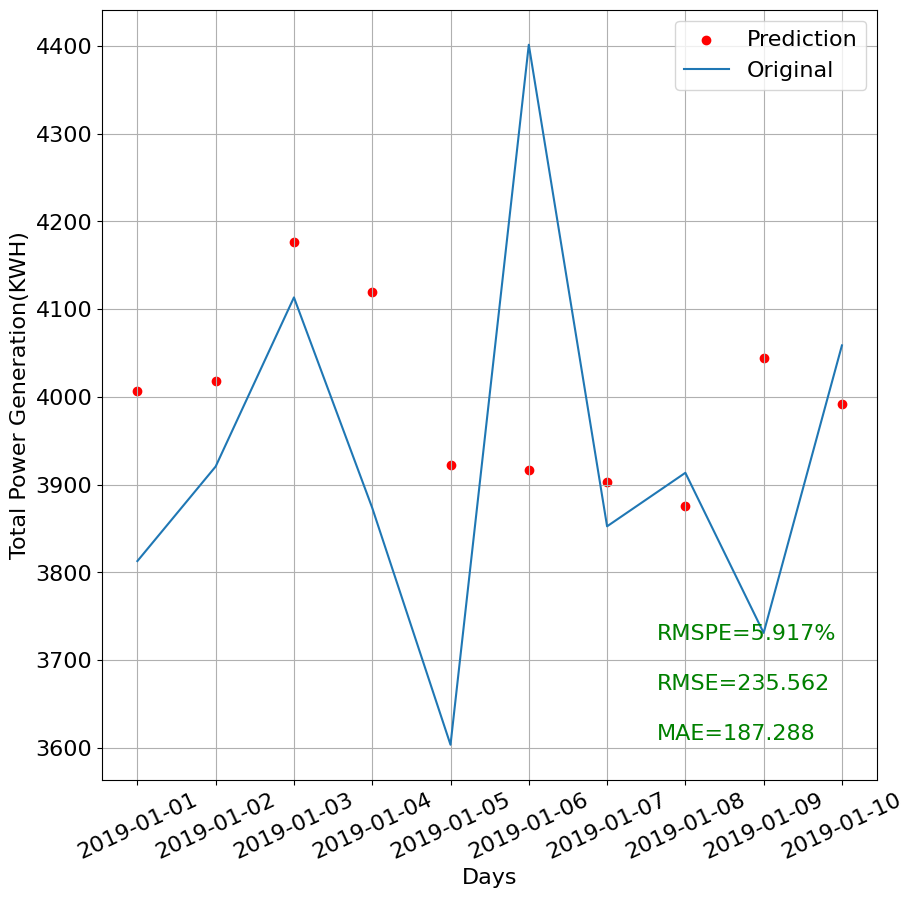

In [44]:
fig = plt.figure(figsize=(10,10))
font = {'size': 16}
plt.rc('font', **font)
plt.scatter('Date', 'Prediction', data=diff_power, label='Prediction', c='r')
plt.plot('Date', 'Original', data=diff_power, label='Original')
plt.legend()
plt.figtext(.68, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.figtext(.68, .2, "RMSE="+str(round(rmse, 3)), c='g')
plt.figtext(.68, .15, "MAE="+str(round(mae, 3)), c='g')
plt.xticks(rotation=25)
plt.grid()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.show()
# plt.title(str(forecast_days)+'_Days Prediction_for_Binary_Var', fontsize=30)

In [45]:
#fig.savefig("result/"+str(forecast_days)+'_Days Prediction_for_Binary', dpi=500)

## Regression conversion

In [46]:
# new_diff_power = 

## Fetching results

In [47]:
# writer = pd.ExcelWriter('12_days.xlsx',engine='xlsxwriter')

In [48]:
# diff_power.to_excel(writer, sheet_name='12_days')

In [49]:
# writer.save()
# writer.close()

## Check the result with regressor

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
df1.head()

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2012-07-06,3218.0,1,0,0,0
2012-07-07,3633.0,1,0,0,0
2012-07-08,4377.0,0,1,0,0
2012-07-09,4625.0,0,1,0,0
2012-07-10,648.0,0,1,0,0


In [52]:
df1.tail()

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2018-12-27,4129.29,1,0,1,0
2018-12-28,4266.50,0,0,1,0
2018-12-29,3732.03,1,0,1,0
2018-12-30,4063.88,0,1,0,0
2018-12-31,4093.90,1,0,1,0


In [53]:
X_train = df1.drop(["Total Generation (KWH)"], axis=1)
Y_train = df1['Total Generation (KWH)']
X_test = diff_power.drop(["Prediction","Original","Difference","Date"], axis=1)

In [54]:
X_train

,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,
2012-07-06,1,0,0,0
2012-07-07,1,0,0,0
2012-07-08,0,1,0,0
2012-07-09,0,1,0,0
2012-07-10,0,1,0,0
...,...,...,...,...
2018-12-27,1,0,1,0
2018-12-28,0,0,1,0
2018-12-29,1,0,1,0


In [55]:
X_test

,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred
0,0.487502,0.919024,0.013340,0.134071
1,0.421920,0.938666,-0.020539,0.074634
2,0.411235,0.924108,-0.006022,0.113328
3,0.372910,0.883409,-0.001627,0.104822
4,0.558229,0.943164,0.006326,0.079327
5,0.394121,0.269509,0.027434,0.299704
6,0.548953,0.986328,0.034072,0.063813
7,0.456653,0.823999,0.074195,0.145397
8,0.339145,0.835986,0.033584,0.128262
9,0.376363,0.850405,0.043758,0.084118


In [56]:
Y_test = diff_power['Original']

In [57]:
Y_test

0    3812.94
1    3920.74
2    4113.45
3    3873.59
4    3603.61
5    4401.37
6    3852.56
7    3913.55
8    3731.08
9    4058.75
Name: Original, dtype: float64

In [58]:
X_train

,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,
2012-07-06,1,0,0,0
2012-07-07,1,0,0,0
2012-07-08,0,1,0,0
2012-07-09,0,1,0,0
2012-07-10,0,1,0,0
...,...,...,...,...
2018-12-27,1,0,1,0
2018-12-28,0,0,1,0
2018-12-29,1,0,1,0


In [59]:
df1.head(5)

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2012-07-06,3218.0,1,0,0,0
2012-07-07,3633.0,1,0,0,0
2012-07-08,4377.0,0,1,0,0
2012-07-09,4625.0,0,1,0,0
2012-07-10,648.0,0,1,0,0


In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
X_test = X_train[-forecast_days:]
X_test

,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,
2018-12-22,1,0,1,0
2018-12-23,1,0,0,0
2018-12-24,1,0,1,0
2018-12-25,0,0,1,0
2018-12-26,0,0,1,0
2018-12-27,1,0,1,0
2018-12-28,0,0,1,0
2018-12-29,1,0,1,0
2018-12-30,0,1,0,0


In [62]:
Y_test = Y_train[-forecast_days:]
Y_test

Date
2018-12-22    3809.72
2018-12-23    3942.46
2018-12-24    2923.51
2018-12-25    3970.89
2018-12-26    4012.14
2018-12-27    4129.29
2018-12-28    4266.50
2018-12-29    3732.03
2018-12-30    4063.88
2018-12-31    4093.90
Name: Total Generation (KWH), dtype: float64

In [63]:
X_train = X_train[:-forecast_days]


In [64]:
X_train

,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,
2012-07-06,1,0,0,0
2012-07-07,1,0,0,0
2012-07-08,0,1,0,0
2012-07-09,0,1,0,0
2012-07-10,0,1,0,0
...,...,...,...,...
2018-12-17,0,0,1,0
2018-12-18,0,0,1,0
2018-12-19,0,0,1,0


In [65]:
Y_train = Y_train[:-forecast_days]
Y_train

Date
2012-07-06    3218.00
2012-07-07    3633.00
2012-07-08    4377.00
2012-07-09    4625.00
2012-07-10     648.00
               ...   
2018-12-17    3696.56
2018-12-18    4082.96
2018-12-19    4042.90
2018-12-20    4103.56
2018-12-21    4175.58
Name: Total Generation (KWH), Length: 2360, dtype: float64

In [66]:
X_train.columns

Index(['Grid Failure', 'Inverter', 'Module Cleaning', 'Cloudy'], dtype='object')

In [67]:
X_test.columns

Index(['Grid Failure', 'Inverter', 'Module Cleaning', 'Cloudy'], dtype='object')

In [68]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))


In [69]:
def rms(y_tst,y_prd):
    return (np.sqrt(mean_squared_error(y_tst, y_prd)**(1/2)))


In [70]:
regr = RandomForestRegressor(max_depth=100, random_state=0, n_jobs=10)
regr.fit(X_train,Y_train)
Y_predrand = regr.predict(X_test)
print(np.sqrt(mean_squared_error(Y_test, Y_predrand)**(1/2)))
# print(r2_score(Y_test, Y_predrand))

21.55834250141312


In [71]:
rms(Y_test, Y_predrand)


21.55834250141312

In [72]:
mae(Y_test, Y_predrand)


340.489067157116

In [73]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [10, 20, 30, 40], 
    'n_jobs':[10],

}

In [74]:
clf = GridSearchCV(regr,parameters)
clf.estimator.get_params().keys()
clf.fit(X_train,Y_train)

GridSearchCV(estimator=RandomForestRegressor(max_depth=100, n_jobs=10,
                                             random_state=0),
             param_grid={'max_depth': [10, 20, 30, 40],
                         'n_estimators': [100, 150, 200, 250, 300],
                         'n_jobs': [10]})

In [75]:
y_pred = clf.predict(X_test)
#mean_squared_error(Y_test, y_pred)**(1/2)
print(np.sqrt(mean_squared_error(Y_test, y_pred)**(1/2)))


21.558342501413115


In [76]:
rms(Y_test, y_pred)


21.558342501413115

In [77]:
mae(Y_test, y_pred)

340.48906715711587

In [78]:
dt = pd.DataFrame(clf.cv_results_)
dt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.415424,0.692477,0.017373,0.004176,10,100,10,"{'max_depth': 10, 'n_estimators': 100, 'n_jobs...",0.066294,0.155772,-0.026233,0.155664,0.225575,0.115414,0.087018,3
1,0.092195,0.002103,0.019536,0.003526,10,150,10,"{'max_depth': 10, 'n_estimators': 150, 'n_jobs...",0.066360,0.155216,-0.027429,0.155895,0.224713,0.114951,0.087154,17
2,0.152207,0.007479,0.029244,0.003902,10,200,10,"{'max_depth': 10, 'n_estimators': 200, 'n_jobs...",0.066642,0.155567,-0.027644,0.156864,0.225102,0.115306,0.087414,13
3,0.149402,0.008413,0.026756,0.004501,10,250,10,"{'max_depth': 10, 'n_estimators': 250, 'n_jobs...",0.066746,0.155820,-0.028459,0.156478,0.226030,0.115323,0.087890,10
4,0.146403,0.005502,0.035166,0.002302,10,300,10,"{'max_depth': 10, 'n_estimators': 300, 'n_jobs...",0.066704,0.156035,-0.029227,0.156950,0.226540,0.115400,0.088338,5
5,0.070952,0.008151,0.016102,0.003111,20,100,10,"{'max_depth': 20, 'n_estimators': 100, 'n_jobs...",0.066294,0.155772,-0.026233,0.155664,0.225575,0.115414,0.087018,4
6,0.091540,0.003571,0.019893,0.003875,20,150,10,"{'max_depth': 20, 'n_estimators': 150, 'n_jobs...",0.066360,0.155216,-0.027429,0.155895,0.224713,0.114951,0.087154,20
7,0.150703,0.007253,0.029809,0.003086,20,200,10,"{'max_depth': 20, 'n_estimators': 200, 'n_jobs...",0.066642,0.155567,-0.027644,0.156864,0.225102,0.115306,0.087414,14
8,0.155198,0.007262,0.032183,0.006469,20,250,10,"{'max_depth': 20, 'n_estimators': 250, 'n_jobs...",0.066746,0.155820,-0.028459,0.156478,0.226030,0.115323,0.087890,12
9,0.166848,0.015175,0.033935,0.006900,20,300,10,"{'max_depth': 20, 'n_estimators': 300, 'n_jobs...",0.066704,0.156035,-0.029227,0.156950,0.226540,0.115400,0.088338,8


In [79]:
dt.loc[dt[dt['rank_test_score']==min(dt['rank_test_score'])].index.values]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.075253,0.001954,0.015978,0.00163,40,100,10,"{'max_depth': 40, 'n_estimators': 100, 'n_jobs...",0.066294,0.155772,-0.026233,0.155664,0.225575,0.115414,0.087018,1


In [80]:
parameters = {
    'n_estimators': [100],
    'max_depth': [30],
    'n_jobs': [10],
}
clf = GridSearchCV(regr, parameters)
clf.estimator.get_params().keys()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
mean_squared_error(Y_test, y_pred)**(1/2)

464.7621314082351

In [81]:
reslut_df = dt[['params','rank_test_score','mean_test_score', 'std_test_score']]
reslut_df = reslut_df.sort_values(by=['rank_test_score'])

In [82]:
#model_score = pd.DataFrame(data=reslut_df.filter(regex=r"split\d*_test_score"), columns=['sc'])
#model_score['sc'] = reslut_df.filter(regex=r"split\d*_test_score")

In [83]:
reslut_df = reslut_df.set_index(reslut_df['rank_test_score'])

C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_21652\1230081465.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=dt['mean_test_score'].iloc[:30],dashes=False, palette="Set1", markers='o')


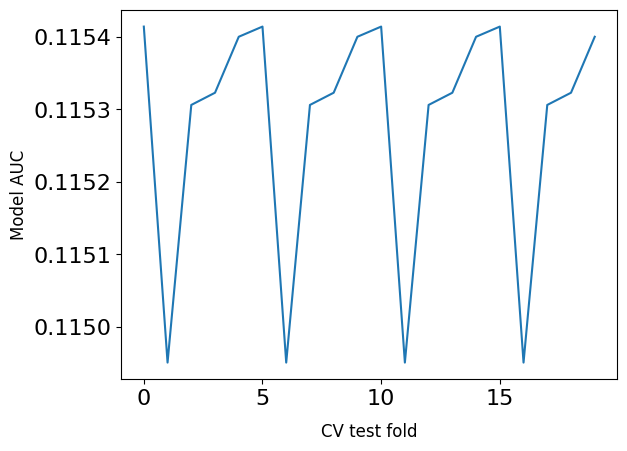

In [84]:
plt.figure()
sns.lineplot(data=dt['mean_test_score'].iloc[:30],dashes=False, palette="Set1", markers='o')
plt.xlabel("CV test fold", size=12, labelpad=10)
plt.ylabel("Model AUC", size=12)
plt.tick_params(bottom=True, labelbottom=True)
#plt.xlabel('rnak')

In [85]:
count = list(range(forecast_days))

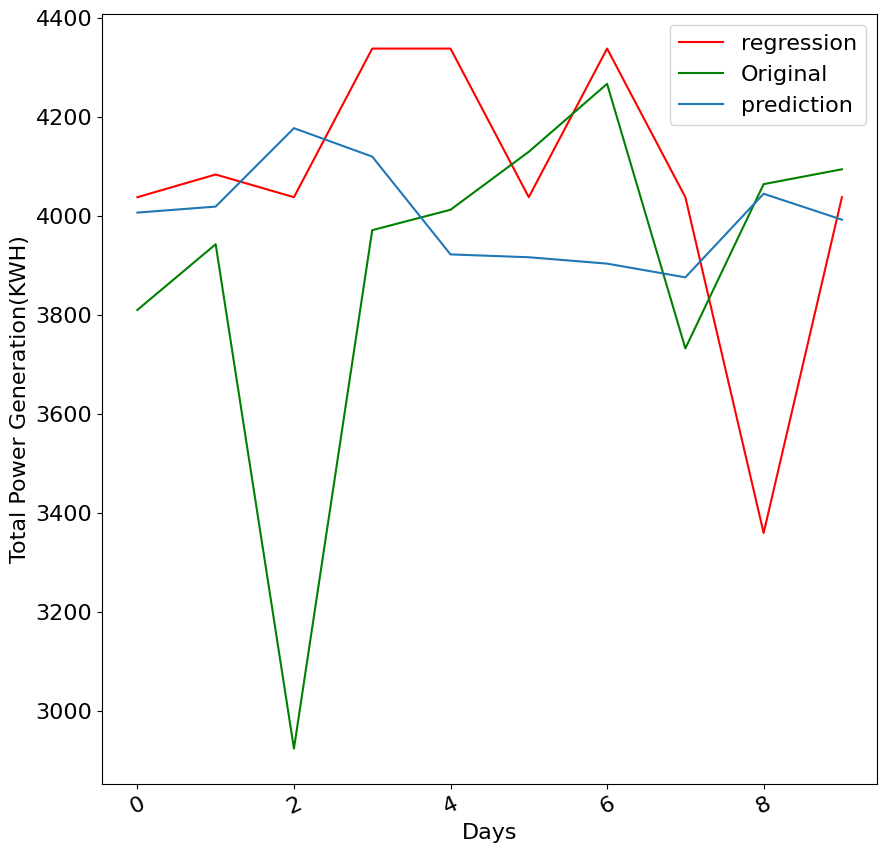

In [86]:
fig = plt.figure(figsize=(10,10))

plt.plot(count, Y_predrand, c="r", label="regression")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
# plt.figtext(.75, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.xticks(rotation=25)
plt.show()

In [87]:
#fig.savefig("result/"+str(forecast_days)+'_Days Prediction_for_regression', dpi=500)

## Thresholding

In [88]:
threshold_dict = dict()
threshold_dict['Grid_pred'] = 0.4
threshold_dict['Module_pred'] = 0.85
threshold_dict['Cloudy_pred'] = 0.1
threshold_dict['Inverter_pred'] = 0.3


In [89]:
new_X_test = pd.DataFrame(columns=X_test.columns)

In [90]:
# new_X_test['Insolation_pred'] = X_test['Insolation_pred']
# new_X_test['NO-OFF-CLEAN MODULES'] = X_test['NO-OFF-CLEAN MODULES']

In [91]:
# X_train = df1.drop(["Total Generation (KWH)"], axis=1)
# Y_train = df1['Total Generation (KWH)']
# X_test = diff_power.drop(["Prediction","Original","Difference","Date"], axis=1)

In [92]:
for index, row in X_test.iterrows():
    for key in threshold_dict.keys():
        if key in X_test.columns:
            new_X_test.loc[index, key] = 1 if row[key] >= threshold_dict[key] else 0

In [93]:
new_X_test

,Grid Failure,Inverter,Module Cleaning,Cloudy


In [94]:
# Y_predrand_thr = regr.predict(new_X_test)
# print(mean_squared_error(Y_test, Y_predrand_thr)**(1/2))

In [95]:
# rmspe = round(np.sqrt(np.mean(np.square(((Y_test - Y_predrand_thr) / Y_test)), axis=0))*100,3)
# rmspe

In [96]:
pd.set_option("display.max_columns", None)

In [97]:
all_data_of_2019 = df_obj['2019'][:forecast_days]

In [98]:
all_data_of_2019

,Date,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Total Generation (KWH),Aggregate Meter Reading (KWH),Difference,SEEDs data (KWH),Insolation,PR (%),Any Issues/Problems Observed,WO#,NO-OFF-CLEAN MODULES,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains
0,2019-01-01,814.0,990.0,947.0,1024.0,37.94,3812.94,3658.50,154.44,3816.0,5.357,0.694288,"Grid Failure From-15:49 to 15:56, Module Clean...",NaN,524.0,1,0,1,0,0,0,0,0,0,0,0,0
1,2019-01-02,809.0,1023.0,988.0,1063.0,37.74,3920.74,3779.25,141.49,3924.0,5.380,0.710885,"Today morning time Inverter No :-4 ,ABB 250KW ...",NaN,441.0,1,0,1,0,0,0,0,0,0,0,0,0
2,2019-01-03,859.0,1046.0,1049.0,1119.0,40.45,4113.45,3995.25,118.20,4117.0,5.598,0.716804,"Grid Failure From-17:19 to 17:20, Module Clean...",NaN,903.0,1,0,1,0,0,0,0,0,0,0,0,0
3,2019-01-04,803.0,1006.0,978.0,1048.0,38.59,3873.59,3717.75,155.84,3877.0,5.136,0.735738,"Module Cleaning has been done in Row-G,H,I,J,K...",NaN,1281.0,0,0,1,0,0,0,0,0,0,0,0,0
4,2019-01-05,775.0,944.0,907.0,943.0,34.61,3603.61,3465.00,138.61,3607.0,4.808,0.731197,"Module Cleaning has been done in Row-A,B,C,D,E...",NaN,792.0,0,0,1,0,0,0,0,0,0,0,0,0
5,2019-01-06,944.0,1153.0,1109.0,1154.0,41.37,4401.37,4240.50,160.87,4405.0,5.946,0.722061,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
6,2019-01-07,842.0,1007.0,972.0,993.0,38.56,3852.56,3697.50,155.06,3860.0,5.184,0.72573,"Module Cleaning has been done in Row-C,D,E,F ...",NaN,630.0,0,0,1,0,0,0,0,0,0,0,0,0
7,2019-01-08,842.0,1017.0,978.0,1038.0,38.55,3913.55,3768.00,145.55,3920.0,5.260,0.726362,"Module Cleaning has been done in Row-,G,H,I,J,...",NaN,936.0,0,0,1,0,0,0,0,0,0,0,0,0
8,2019-01-09,798.0,955.0,928.0,1013.0,37.08,3731.08,3588.75,142.33,3735.0,5.008,0.726907,"Grid Failure From-12:28 to 12:35, Module Clean...",NaN,816.0,1,0,1,0,0,0,0,0,0,0,0,0
9,2019-01-10,847.0,1035.0,1033.0,1104.0,39.75,4058.75,3912.00,146.75,4062.0,5.336,0.741954,"Module Cleaning has been done in Row-K,L,M,N, ...",NaN,987.0,0,0,1,0,0,0,0,0,0,0,0,0


In [99]:
#df_obj['2019'][]

In [100]:
new_X_test

,Grid Failure,Inverter,Module Cleaning,Cloudy


In [101]:
rmspe = round(np.sqrt(np.mean(np.square(((Y_test - Y_predrand_thr) / Y_test)), axis=0))*100,3)
rmspe

NameError: name 'Y_predrand_thr' is not defined

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.plot(count, Y_predrand_thr, c="r", label="With Threshold")
plt.plot(count, Y_predrand, c="black", label="Without Threshold")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
# plt.figtext(.15, .75, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.xticks(rotation=25)
plt.show()

In [ ]:
#fig.savefig("result/"+str(forecast_days)+'_Days Prediction_for_threshold_without_threshold_regression', dpi=500)

## XG Boost

In [ ]:
#pip install xgboost

In [ ]:
# Instantiation
import xgboost as xg

In [ ]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, Y_train)

In [ ]:
check_x_test = new_X_test.to_numpy()

In [ ]:
check_x_test

In [ ]:
# Predict the model
# pred = xgb_r.predict(check_x_test)
pred = xgb_r.predict(X_test)

In [ ]:
pred

In [ ]:
rms(Y_test, pred)

In [ ]:
mae(Y_test, pred)

In [ ]:
# RMSE Computation
rmse = round(np.sqrt(np.mean(np.square(((Y_test - pred) / Y_test)), axis=0))*100,3)
print("RMSPE : % f" %(rmse))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
clf = GridSearchCV(xgb_r,parameters)
clf.fit(X_train,Y_train)
# y_pred = clf.predict(check_x_test)
y_pred = clf.predict(X_test)
#warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
rms(Y_test, y_pred)


In [ ]:
mae(Y_test, y_pred)


In [ ]:
# RMSE Computation
rmse = round(np.sqrt(np.mean(np.square(((Y_test - y_pred) / Y_test)), axis=0))*100,3)
print("RMSPE : % f" %(rmse))

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.plot(count, pred, c="r", label="With XGBoost")
# plt.plot(count, Y_predrand, c="black", label="Without Threshold")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
# plt.figtext(.15, .75, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.xticks(rotation=25)
plt.grid()
plt.show()

## new pattern wise scatter plot

In [ ]:
previous_power = df_obj['2018']['Total Generation (KWH)'][-lag:]

In [ ]:
diff_power['Prediction']

In [ ]:
fig = plt.figure(figsize=(10,10))
font = {'size': 16}
plt.rc('font', **font)
range1 = range(len(previous_power))
range2 = range(len(previous_power), len(previous_power)+len(diff_power['Prediction']))
plt.scatter(range1, previous_power, c="r")
plt.plot(range1, previous_power, c="r", label="Previous_Original")
plt.scatter(range2, diff_power['Prediction'], c="g")
plt.plot(range2, diff_power['Prediction'], c="g", label="Prediction")
# plt.scatter('Date', 'Prediction', data=diff_power, label='Prediction', c='r')
plt.scatter(range2, diff_power['Original'])
plt.plot(range2, diff_power['Original'], label='Original')
plt.legend()
# plt.figtext(.68, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
# plt.figtext(.68, .2, "RMSE="+str(round(rmse, 3)), c='g')
# plt.figtext(.68, .15, "MAE="+str(round(mae, 3)), c='g')
plt.xticks(rotation=25)
plt.grid()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.show()
# plt.title(str(forecast_days)+'_Days Prediction_for_Binary_Var', fontsize=30)

In [ ]:
#spider graph/chart

## Arima

In [ ]:
import statsmodels as sm
from statsmodels.tsa.vector_ar.var_model import 

In [ ]:
mod = sm.tsa.VARMAX()
# endog, order = (1, 0, 0))

In [ ]:
res_default_timeseries = sm.tsa.vector_ar.var_model.TimeSeriesModel(endog_array)

In [ ]:
res_default_timeseries.predict(df1[:forecast_days])

# LSTM

i am in
<class 'str'>
         Date  Total Generation (KWH)  Insolation  Grid Failure  Inverter  \
0  2012-07-06                  3218.0     9.37536             1         0   
1  2012-07-07                  3633.0     9.37536             1         0   
2  2012-07-08                  4377.0     9.37536             0         1   
3  2012-07-09                  4625.0     9.37536             0         1   
4  2012-07-10                   648.0     9.37536             0         1   

   Module Cleaning  Rainy day  No Module Cleaning  \
0                0          0                   0   
1                0          0                   0   
2                0          0                   0   
3                0          0                   0   
4                0          0                   0   

   Transformer replacement and maintenance  Cable and Fuse maintenance  \
0                                        0                           0   
1                                        0      

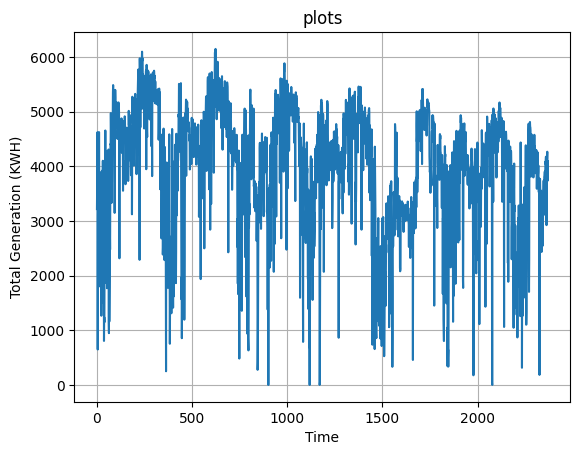

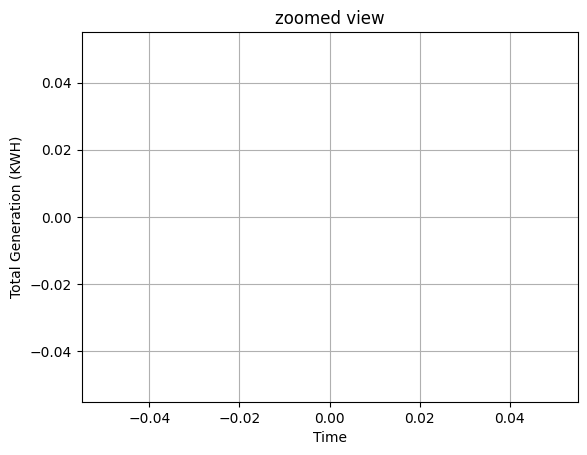

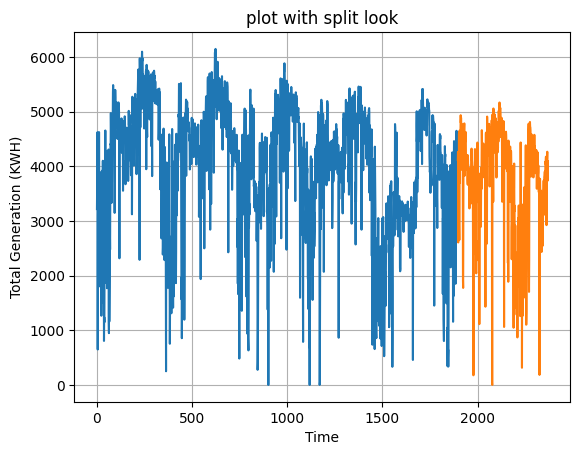

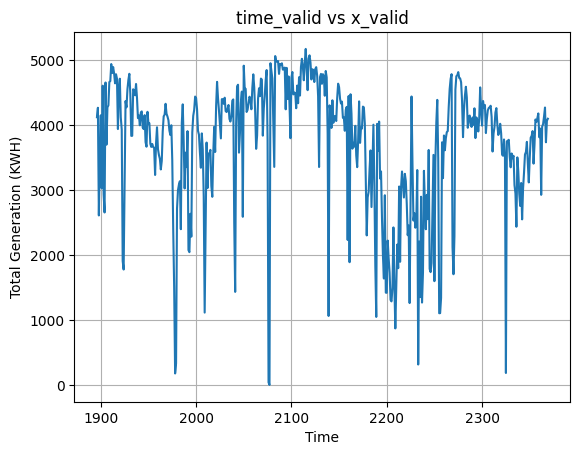

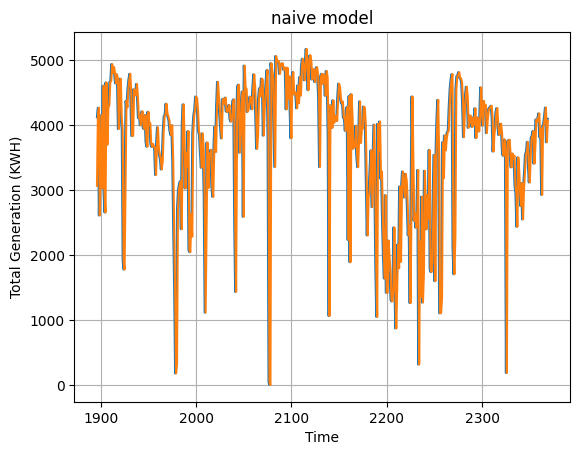

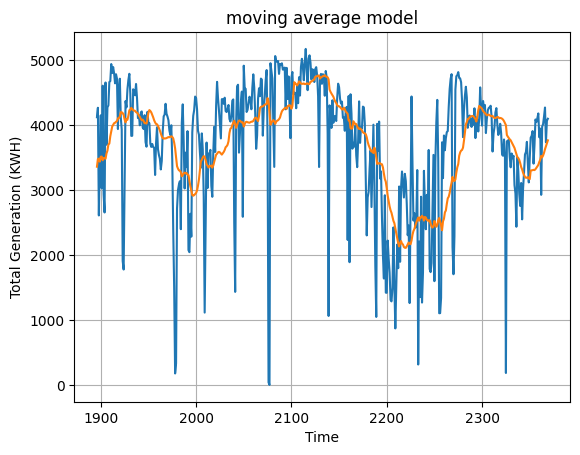

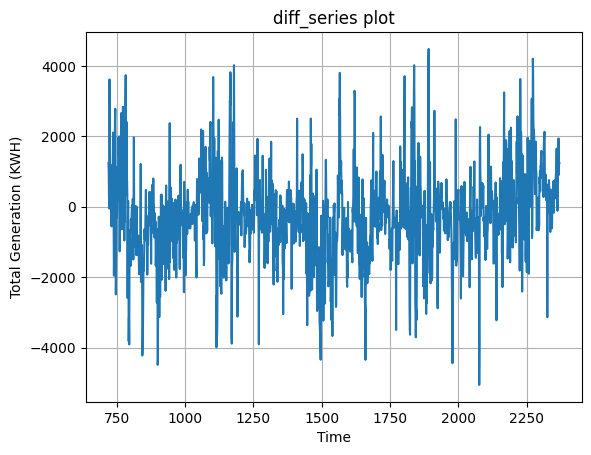

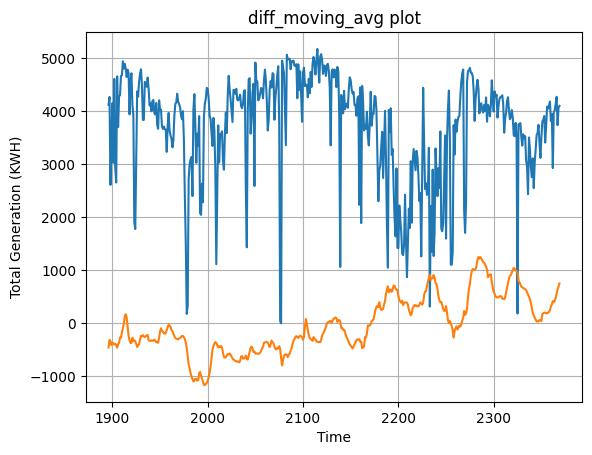

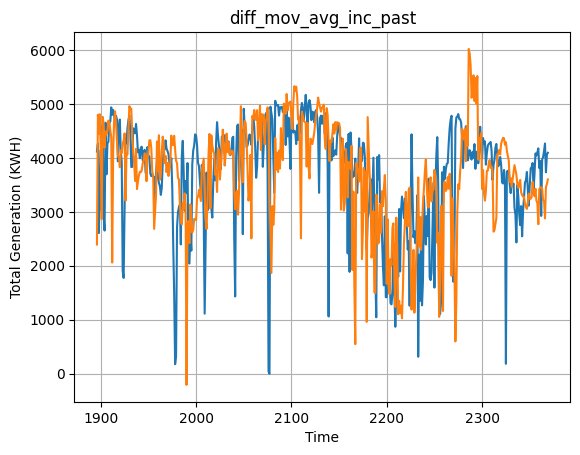

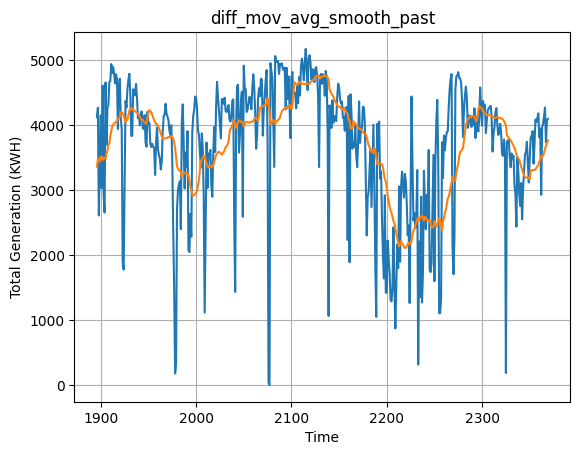

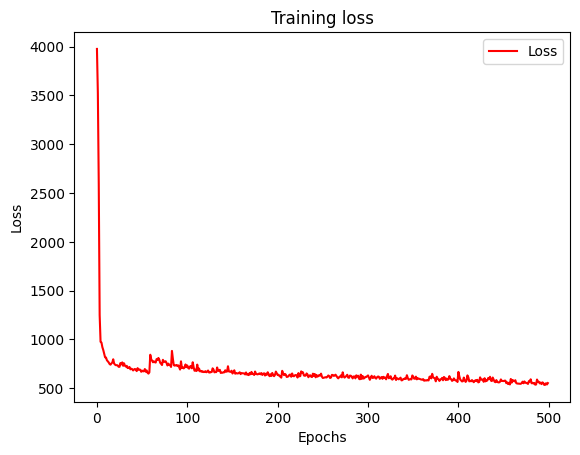

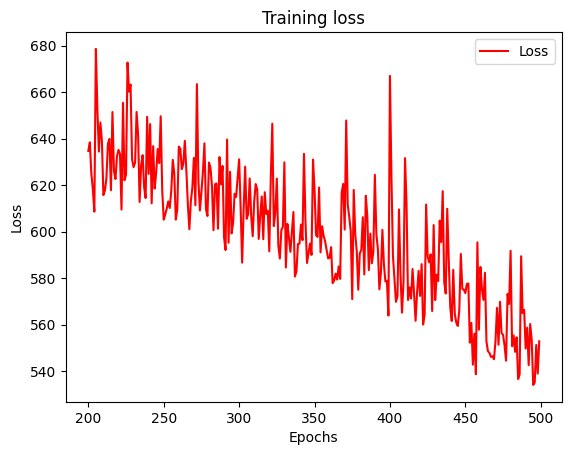

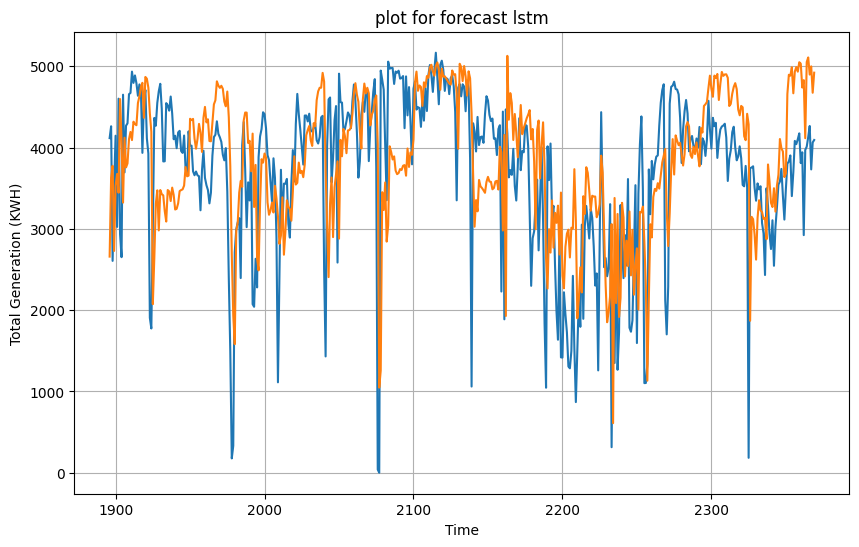

In [ ]:
import time_series_3 as ts

In [ ]:
df1 = df1.rename(columns={'Total Generation (KWH)':'Total_genration_kwh'})
df1

In [ ]:
ts.data('out_clean.csv','Total Generation (KWH)')

In [ ]:
df.head()

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
TimeseriesGenerator(
    df,
    df['Total Generation (KWH)'],
    length=15,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=128
)

i am in
<class 'str'>
         Date  Total Generation (KWH)  Insolation  Grid Failure  Inverter  \
0  2012-07-06                  3218.0     9.37536             1         0   
1  2012-07-07                  3633.0     9.37536             1         0   
2  2012-07-08                  4377.0     9.37536             0         1   
3  2012-07-09                  4625.0     9.37536             0         1   
4  2012-07-10                   648.0     9.37536             0         1   

   Module Cleaning  Rainy day  No Module Cleaning  \
0                0          0                   0   
1                0          0                   0   
2                0          0                   0   
3                0          0                   0   
4                0          0                   0   

   Transformer replacement and maintenance  Cable and Fuse maintenance  \
0                                        0                           0   
1                                        0      

TypeError: 'function' object is not subscriptable

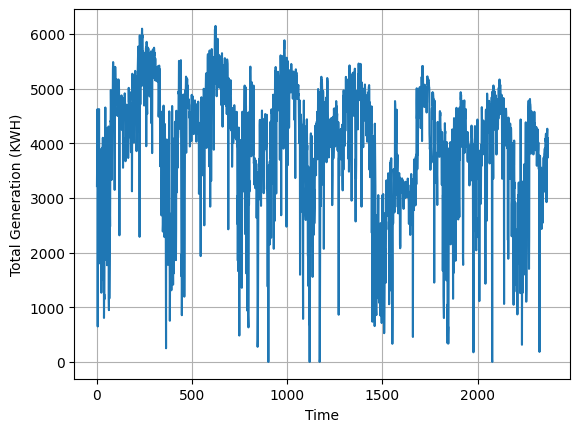

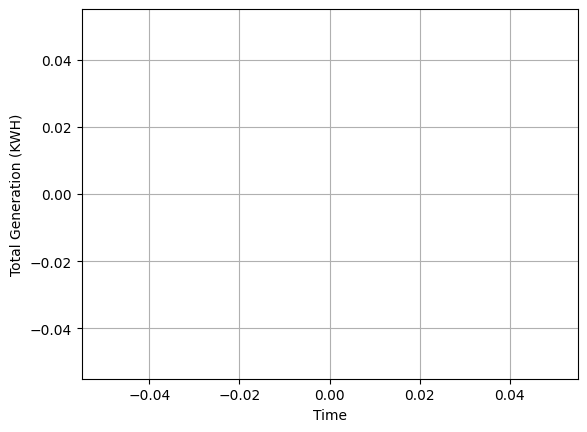

In [ ]:
import tensorflow as tf
import pandas as pd
#import dask.dataframe as pd
#import dask.array as np
import numpy as np
import matplotlib.pyplot as plt
#import streamlit as st
#import tf.keras.preprocessing.sequence.TimeseriesGenerator


def plot_series(time, series, target, format="-", start=0, end=None):
    #with st.container():
    #fig = plt.figure()
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel(target)
    plt.grid(True)
    # st.pyplot(fig)


def window_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    return model.predict(ds)


def moving_avg_forcast(series, window_size):
    forcast = [
        series[time:time + window_size].mean()
        for time in range(len(series) - window_size)
    ]
    return np.array(forcast)


def naive_model(series, split_time, time_train, time_valid, x_train, x_valid, target):
    naive_forcast = series[split_time - 1:-1]
    print('naive_model that is our base model')
    # nav_fig = plt.figure()
    plt.figure()
    plot_series(time_valid, x_valid, target)
    plot_series(time_valid, naive_forcast, target)
    # st.pyplot(nav_fig)
    base_mea = tf.keras.metrics.mean_absolute_error(
        x_valid, naive_forcast).numpy()
    print('base_mea', base_mea)

# @st.cache(ttl=7200)


def data(filename, target):
    print('i am in')
    time_stamp = []
    series = []
    print(type(filename))
    try:
        dat = pd.read_csv(filename)
        print(dat.head())
        #dat['datetime'] = pd.to_datetime(dat['datetime'])
        print(dat.info())
        dat = dat.dropna()
        print(dat.isna().sum())
        print(dat.info())
    except:
        print('enter except')
        print(type(filename))
        print('1')
        #dat = dat.join(dat.pop('data').apply(pd.Series))
        if isinstance(filename, pd.DataFrame):
            # if type(filename) == pd.core.frame.DataFrame:
            print('enter if')
            dat = filename
            print(dat.info())
            print(dat.tail(10))
        else:
            print('not loading data!!!!!')
    print('pikachu')
    series = np.array(list(pd.to_numeric(dat[target])))
    time_stamp = np.array(list(dat.index)).astype('float64')
    print('series ------>>>>>\n', series)
    print('time_stamp ------>>>>>>>\n', time_stamp)
    print('converted')
    #series = np.array(pd.to_numeric(dat[target]))
    #time_stamp = np.array(pd.to_numeric(list(dat.index)).astype('float64'))
    # with st.container():
    #     print('converted')
    #     col1, col2 = st.columns(2)
    #     with col1:
    #         print('series:', series)
    #     with col2:
    #         print('time_stamp:', time_stamp)

    # basic_fig = plt.figure()
    plt.figure()
    print('plots')
    plot_series(time_stamp, series, target)
    # st.pyplot(basic_fig)
    # zoomed_fig = plt.figure()
    plt.figure()
    print('zommed view')
    plot_series(time_stamp[2500:2600], series[2500:2600], target)
    # st.pyplot(zoomed_fig)

    "--------------------------------------------------------"
    feature_time = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        dat,
        dat[target],
        length=15,
        sampling_rate=1,
        stride=1,
        start_index=0,
        end_index=None,
        shuffle=False,
        reverse=False,
        batch_size=128
    )
    "--------------------------------------------------------"
    # dat = dat.drop(['Total Generation (KWH)','Date'], axis=1)
    dat = data[['Grid Failure', 'Inverter', 'Module Cleaning', 'Cloudy']]
    arr = dat.to_numpy()
    arr=[[arr]]
    print('arr:------------->>>\n',arr)
    split_time = int(len(time_stamp)*80/100)
    #time_train_p = time_stamp[:split_time]
    #time_valid_p = time_stamp[split_time:]
    time_train_p = arr[:split_time] # train features
    time_valid_p = arr[split_time:] # test features
    x_train = series[:split_time] # train target
    x_valid = series[split_time:] # test target

    print('-------------------------------------------------')
    print(arr.shape)
    print(time_train_p)
    print('-------------------------------------------------')

    # print(len(time_train))
    # print(len(time_valid))
    # print(len(x_train))
    # print(len(x_valid))
    print('plot with split look')
    # fig1 = plt.figure()
    plt.figure()
    plot_series(time_train_p, x_train, target)
    plot_series(time_valid_p, x_valid, target)
    # st.pyplot(fig1)
    # fig2 = plt.figure()
    plt.figure()
    print('time_valid vs x_valid')
    plot_series(time_valid_p, x_valid, target)
    # st.pyplot(fig2)

    window_size = 60
    batch_size = 256
    shuffle_buffer_size = 1000

    naive_model(series, split_time, time_train_p,
                time_valid_p, x_train, x_valid, target)

    def moving_avg():
        moving_avg = moving_avg_forcast(series, 25)[split_time-25:]
        # len(moving_avg)
        print('moving average model that is our check model')
        # fig3 = plt.figure()
        plt.figure()
        plot_series(time_valid_p, x_valid, target)
        plot_series(time_valid_p, moving_avg, target)
        # st.pyplot(fig3)
        mea_mov_avg = tf.keras.metrics.mean_absolute_error(
            x_valid, moving_avg).numpy()
        print('mea:', mea_mov_avg)

        diff_series = series[720:]-series[:-720]
        diff_time = time_stamp[720:]
        print('diff_series')
        # fig4 = plt.figure()
        plt.figure()
        plot_series(diff_time, diff_series, target)
        # st.pyplot(fig4)

        diff_moving_avg = moving_avg_forcast(diff_series, 25)[
            split_time-720-25:]
        len(diff_moving_avg)
        print('diff_moving_avg')
        # fig5 = plt.figure()
        plt.figure()
        plot_series(time_valid_p, x_valid, target)
        plot_series(time_valid_p, diff_moving_avg, target)
        # st.pyplot(fig5)
        mea_mov_avg_diff = tf.keras.metrics.mean_absolute_error(
            x_valid, diff_moving_avg).numpy()
        print('mea:', mea_mov_avg_diff)

        diff_mov_avg_inc_past = series[split_time-720:-720]+diff_moving_avg
        print('diff_mov_avg_inc_past')
        # fig6 = plt.figure()
        plt.figure()
        plot_series(time_valid_p, x_valid, target)
        plot_series(time_valid_p, diff_mov_avg_inc_past, target)
        # st.pyplot(fig6)
        mea_mov_avg_diff_past = tf.keras.metrics.mean_absolute_error(
            x_valid, diff_moving_avg).numpy()
        print('mea:', mea_mov_avg_diff_past)

        diff_mov_avg_smooth_past = moving_avg_forcast(
            series[split_time-745:-720], 25)
        diff_mov_avg_smooth_past = diff_mov_avg_smooth_past + diff_moving_avg
        print('diff_mov_avg_smooth_past')
        # fig7 = plt.figure()
        plt.figure()
        plot_series(time_valid_p, x_valid, target)
        plot_series(time_valid_p, diff_mov_avg_smooth_past, target)
        # st.pyplot(fig7)
        final_mov_avg_mea = tf.keras.metrics.mean_absolute_error(
            x_valid, diff_mov_avg_smooth_past).numpy()
        print('mea:', final_mov_avg_mea)
    # @st.cache(ttl=7200)

    def try_train():
        print('train dnn trying....')
        # down_code
        tf.keras.backend.clear_session()
        tf.random.set_seed(51)
        np.random.seed(51)
        window_size = 64
        batch_size = 256
        train_set = window_dataset(
            x_train, window_size, batch_size, shuffle_buffer_size)
        print(train_set)
        print(x_train.shape)

        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                                   strides=1, padding="causal",
                                   activation="relu",
                                   input_shape=[None, 1]),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 400)
        ])

        lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch / 20))
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])
        history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

        plt.semilogx(history.history["lr"], history.history["loss"])
        plt.axis([1e-8, 1e-4, 0, 300])

        """-------------"""
        loss = history.history['loss']
        epochs = range(len(loss))  # Get number of epochs
        # ------------------------------------------------
        # Plot training and validation loss per epoch
        # ------------------------------------------------
        # fig8 = plt.figure()
        plt.figure()
        plt.plot(epochs, loss, 'r')
        plt.title('Training loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss"])
        # st.pyplot(fig8)

    """-------------"""
    print('train dnn final')
    # @st.cache(ttl=7200)

    def train():
        rmse = tf.keras.metrics.RootMeanSquaredError()
        tf.keras.backend.clear_session()
        tf.random.set_seed(51)
        np.random.seed(51)
        "---------------------------"
        train_data = tf.data.Dataset.from_tensor_slices((time_train_p, x_train))
        train_data = train_data.cache().shuffle(
            shuffle_buffer_size).batch(batch_size).repeat()
        val_data = tf.data.Dataset.from_tensor_slices((time_valid_p, x_valid))
        val_data = val_data.batch(batch_size).repeat() 
        "---------------------------"
        train_set = window_dataset(
            train_data, window_size=60, batch_size=256, shuffle_buffer_size=shuffle_buffer_size)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                                   strides=1, padding="causal",
                                   activation="relu",
                                   input_shape=[None, 1]),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(256, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 400)
        ])
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])
        history = model.fit(train_set, epochs=10)
        #history = model.fit(train_set, epochs=500)
        return history, model

    """-------------"""
    def train_loss(history):
        print('train losses')
        loss = history.history['loss']
        epochs = range(len(loss))  # Get number of epochs

        # ------------------------------------------------
        # Plot training and validation loss per epoch
        # ------------------------------------------------
        # fig9 = plt.figure()
        plt.figure()
        plt.plot(epochs, loss, 'r')
        plt.title('Training loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss"])
        # st.pyplot(fig9)

        try: 
            zoomed_loss = loss[200:]
            zoomed_epochs = range(200, 500)

            # ------------------------------------------------
            # Plot training and validation loss per epoch
            # ------------------------------------------------
            # fig10 = plt.figure()
            plt.figure()
            plt.plot(zoomed_epochs, zoomed_loss, 'r')
            plt.title('Training loss')
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend(["Loss"])
            # st.pyplot(fig10)
        except:
            print(' ')

    """-------------"""
    moving_avg()
    # try_train()
    history, model = train()
    train_loss(history)

    """-------------"""

    forecast = model_forecast(
        model, series[..., np.newaxis], window_size, batch_size)
    forecast = forecast[split_time - window_size:-1, -1, 0]
    print(forecast)

    print('plot for forecast')
    # fig11 = plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 6))
    plot_series(time_valid_p, x_valid, target)
    plot_series(time_valid_p, forecast, target)
    # st.pyplot(fig11)

    mea = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
    print('mea:', mea)

    def mae_py(y_true, predictions):
        y_true, predictions = np.array(y_true), np.array(predictions)
        return np.mean(np.abs(y_true - predictions))
    mean_abs_err = mae_py(x_valid, forecast)
    print(mean_abs_err)

"""-------------"""
# data('all_data_bike2.csv','count')
data('out_clean.csv', 'Total Generation (KWH)')